<a href="https://colab.research.google.com/github/KatBCN/ML-PropertyAssessment/blob/main/ML_Modeling_LinearRegression2_PropertyAssessment_Buffalo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression

This notebook contains models for OLS , Lasso, Ridge, and Huber Linear Regression models, using two different sets of features.

In [4]:
# import libraries
from google.colab import drive 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import power_transform
#from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from scipy import stats
from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')

# set seed
np.random.seed(42)

# set options
pd.set_option('display.max_columns', None) 
sns.set()

# mount drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/ML/ML-Project/data/
%ls 

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/ML/ML-Project/data
imputed/  initial_splits/  metadata/  preprocessed/  results/  source_data/


This notebook uses data from the preprocessed data folder.

In [5]:
# load train data
df = pd.read_pickle("/content/drive/MyDrive/ML/ML-Project/data/imputed/train_BuffaloProperty.pkl")

val_df = pd.read_pickle("/content/drive/MyDrive/ML/ML-Project/data/imputed/validation_BuffaloProperty.pkl")


- Data from the Imputed folder:
  - The training data set has 35,921 rows and 21 columns.
  - The validation data set has 12,020 rows and 21 columns

In [6]:
print(df.shape)
print(val_df.shape)

(35921, 21)
(12020, 21)


In [7]:
print(df.dtypes)
print(val_df.dtypes)

Front                          float64
Depth                          float64
Sale Price                     float64
Year Built                     float64
Total Living Area              float64
# of Fireplaces                  int64
# of Beds                        int64
Latitude                       float64
Longitude                      float64
TotalBaths                       int64
Property Class Description    category
Overall Condition             category
Building Style                category
Heat Type                     category
Basement Type                 category
Neighborhood                  category
SameOwnerLastName             category
OwnershipType                 category
PropertyClassReformed         category
Sale Type                       object
Total Value                    float64
dtype: object
Front                          float64
Depth                          float64
Sale Price                     float64
Year Built                     float64
Total Livin

There are no missing values in this data, because it has been pre-processed with outlier detection and imputation.

In [8]:
print("Count of null values per column:")
print(df.isna().sum())

Count of null values per column:
Front                         0
Depth                         0
Sale Price                    0
Year Built                    0
Total Living Area             0
# of Fireplaces               0
# of Beds                     0
Latitude                      0
Longitude                     0
TotalBaths                    0
Property Class Description    0
Overall Condition             0
Building Style                0
Heat Type                     0
Basement Type                 0
Neighborhood                  0
SameOwnerLastName             0
OwnershipType                 0
PropertyClassReformed         0
Sale Type                     0
Total Value                   0
dtype: int64


Sale Price may not be a very reliable variable to use. The imputation allowed a nonrealistic value to appear which is negative. The imputer should be checked to make sure 0 is the minimum imputation value.

We still have Front and Total Living Area minimum values of 1, which I thought would be outliers...

In [9]:
df.describe(include='all')

,Front,Depth,Sale Price,Year Built,Total Living Area,# of Fireplaces,# of Beds,Latitude,Longitude,TotalBaths,Property Class Description,Overall Condition,Building Style,Heat Type,Basement Type,Neighborhood,SameOwnerLastName,OwnershipType,PropertyClassReformed,Sale Type,Total Value
count,35921.000000,35921.000000,35921.000000,35921.000000,35921.000000,35921.000000,35921.000000,35921.000000,35921.000000,35921.000000,35921,35921,35921,35921,35921,35921,35921,35921,35921,35921,35921.00000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,5,18,4,4,36,2,3,2,2,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ONE FAMILY DWELLING,3,08,2,4,South Park,Different name,Person,No reform,Real Sale,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20969,32307,30855,29811,27644,2863,27225,32436,35751,21439,NaN
mean,36.008568,118.405144,65726.273247,1919.137218,1816.461696,0.137691,4.054481,42.910772,-78.622463,1.692464,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62981.46104
std,8.918574,23.124106,60495.573411,24.527781,615.423821,0.405385,1.303909,0.034926,4.154282,0.611045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52493.43274
min,5.000000,17.000000,0.000000,1800.000000,401.000000,0.000000,0.000000,42.832090,-78.908661,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000.00000
25%,30.000000,105.000000,26000.000000,1900.000000,1325.000000,0.000000,3.000000,42.890035,-78.864922,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32000.00000
50%,33.000000,115.000000,49000.000000,1920.000000,1708.000000,0.000000,4.000000,42.917171,-78.834920,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48900.00000
75%,40.000000,130.000000,84000.000000,1927.000000,2244.000000,0.000000,5.000000,42.940270,-78.814865,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74000.00000


In [10]:
df["Age"] = 2020 - df["Year Built"]
val_df["Age"] = 2020 - val_df["Year Built"]

## Data exploration
Exploring percentages of categorical data present in the data.

In [11]:
df['Property Class Description'].value_counts(normalize=True)

ONE FAMILY DWELLING    0.583753
TWO FAMILY DWELLING    0.416247
Name: Property Class Description, dtype: float64

Confirming the validation set contains similar proportions of property classes:

In [12]:
val_df['Property Class Description'].value_counts(normalize=True)

ONE FAMILY DWELLING    0.585025
TWO FAMILY DWELLING    0.414975
Name: Property Class Description, dtype: float64

In [13]:
df['OwnershipType'].value_counts(normalize=True)

Person         0.902982
Corporation    0.094318
Buffalo        0.002700
Name: OwnershipType, dtype: float64

In [14]:
df['Heat Type'].value_counts(normalize=True)

2    0.829905
3    0.115754
1    0.052810
4    0.001531
Name: Heat Type, dtype: float64

In [15]:
df['Basement Type'].value_counts(normalize=True)

4    0.769578
3    0.133766
2    0.051363
1    0.045294
Name: Basement Type, dtype: float64

In [16]:
df['Overall Condition'].value_counts(normalize=True)

3    0.899390
2    0.052810
4    0.039865
1    0.007684
5    0.000251
Name: Overall Condition, dtype: float64

In [17]:
df['Building Style'].value_counts(normalize=True)

08    0.858968
04    0.058684
05    0.033769
01    0.025361
15    0.007322
14    0.004176
12    0.003981
10    0.001782
13    0.001754
02    0.001475
03    0.001114
09    0.000752
06    0.000334
8     0.000195
5     0.000167
1     0.000084
17    0.000056
07    0.000028
Name: Building Style, dtype: float64

I will create a new column called "Age" which is the year 2020 - Year Built

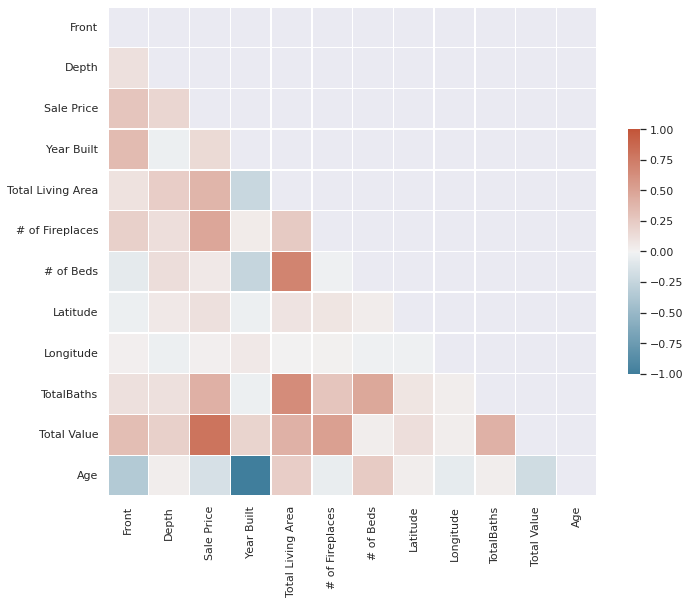

In [18]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin= -1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

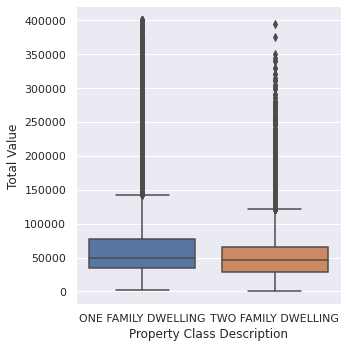

In [19]:
sns.catplot(x="Property Class Description", y="Total Value", kind="box", data=df)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35]), <a list of 36 Text major ticklabel objects>)

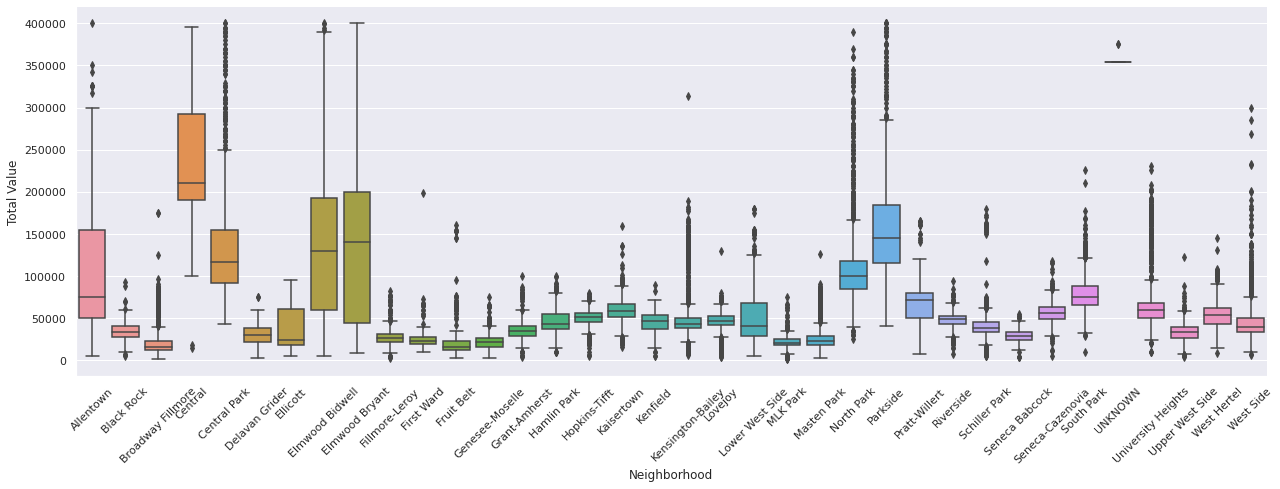

In [20]:

sns.catplot(x="Neighborhood", y="Total Value", kind="box", data=df, height=6, aspect=3)
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]), <a list of 18 Text major ticklabel objects>)

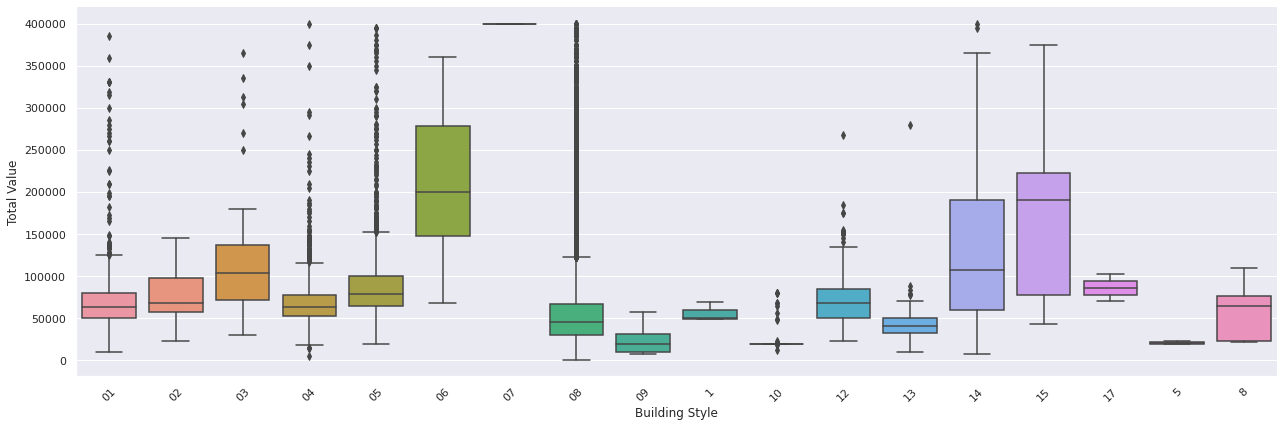

In [21]:
sns.catplot(x="Building Style", y="Total Value", kind="box", data=df, height=6, aspect=3)
plt.xticks(rotation=45)

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

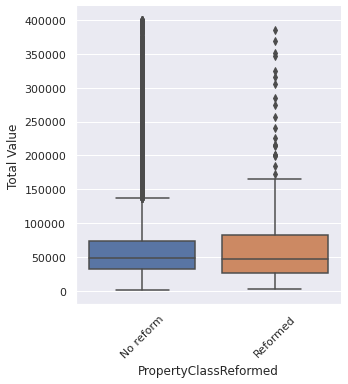

In [22]:
sns.catplot(x="PropertyClassReformed", y="Total Value", kind="box", data=df)
plt.xticks(rotation=45)

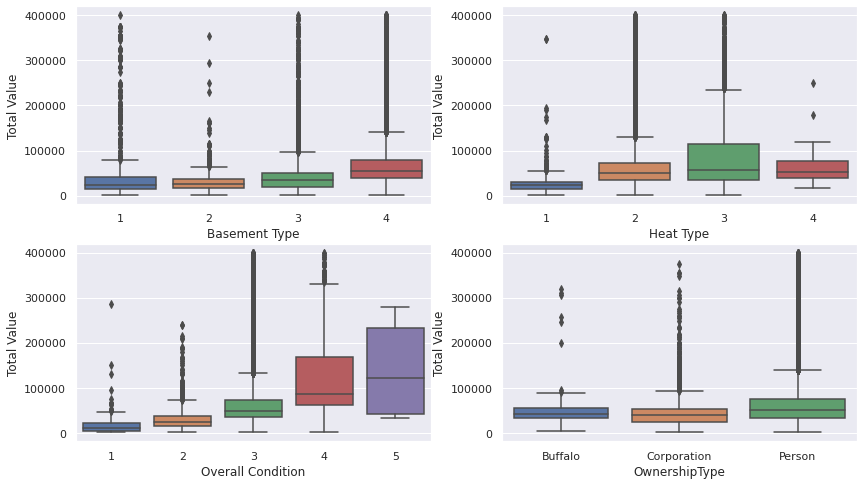

In [23]:
#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2, figsize = (14,8))

#create boxplot in each subplot
sns.boxplot(data=df, x='Basement Type', y='Total Value', ax=axes[0,0])
sns.boxplot(data=df, x='Heat Type', y='Total Value', ax=axes[0,1])
sns.boxplot(data=df, x='Overall Condition', y='Total Value', ax=axes[1,0])
sns.boxplot(data=df, x='OwnershipType', y='Total Value', ax=axes[1,1])

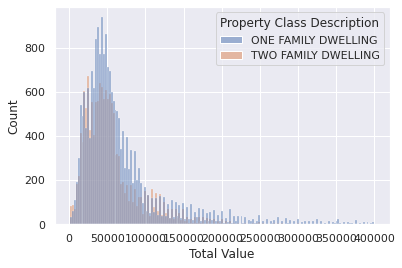

In [24]:
sns.histplot(data=df, x='Total Value', hue = "Property Class Description")

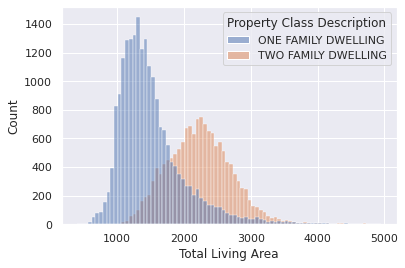

In [25]:
sns.histplot(data=df, x='Total Living Area', hue="Property Class Description")

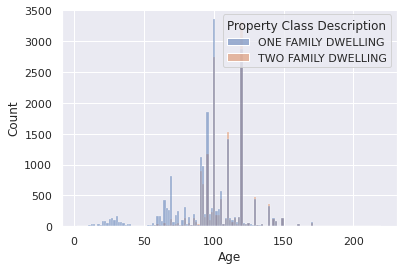

In [26]:
sns.histplot(data=df, x='Age', hue="Property Class Description")

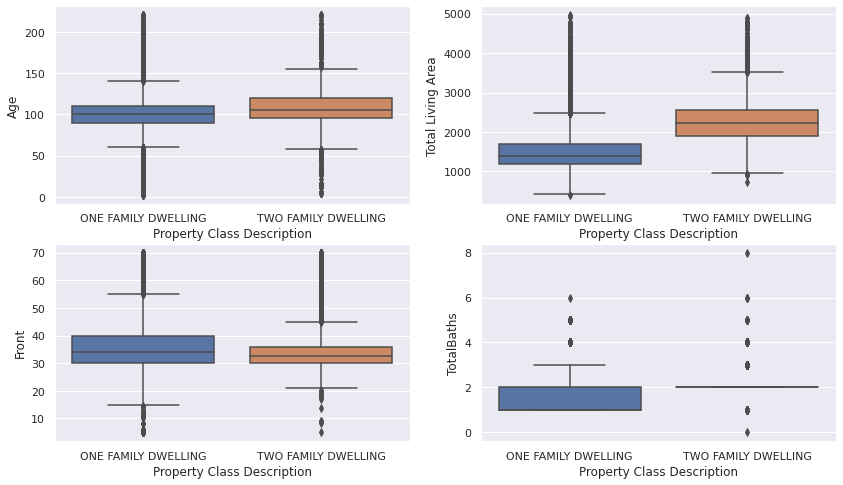

In [27]:
#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2, figsize = (14,8))

#create boxplot in each subplot
sns.boxplot(data=df, x='Property Class Description', y='Age', ax=axes[0,0])
sns.boxplot(data=df, x='Property Class Description', y='Total Living Area', ax=axes[0,1])
sns.boxplot(data=df, x='Property Class Description', y='Front', ax=axes[1,0])
sns.boxplot(data=df, x='Property Class Description', y='TotalBaths', ax=axes[1,1])

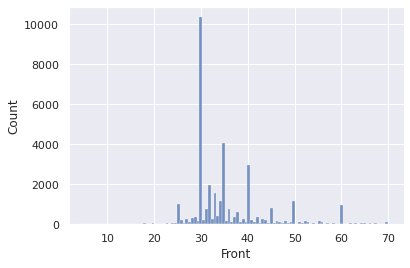

In [28]:
sns.histplot(data=df, x='Front')

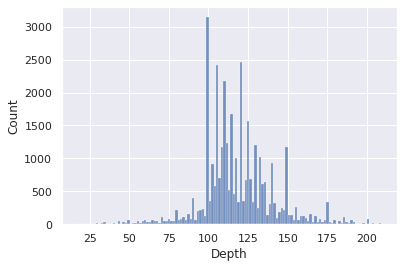

In [29]:
sns.histplot(data=df, x='Depth')

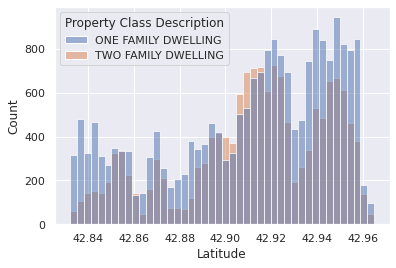

In [30]:
sns.histplot(data=df, x='Latitude', hue="Property Class Description")

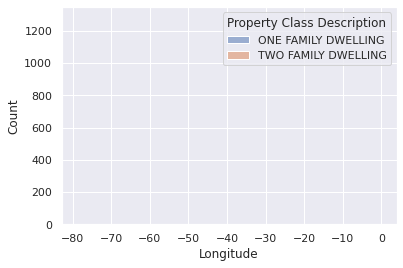

In [31]:
sns.histplot(data=df, x='Longitude', hue="Property Class Description")

Sale Price may not be the most reliable variable since it was imputed.

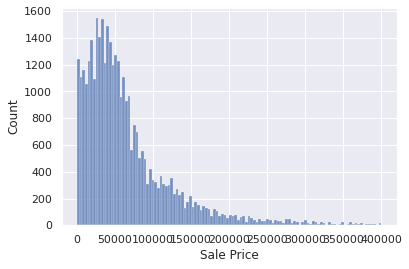

In [32]:
sns.histplot(data=df, x='Sale Price')

* [sklearn.preprocessing.PowerTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html)
* [sklearn.pipeline.Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline)
* [How to Transform Target Variables for Regression in Python](https://machinelearningmastery.com/how-to-transform-target-variables-for-regression-with-scikit-learn/)

## Functions for running Regression Models

Regression Metrics:
- MSE: Mean squared error, closer to 0 is better. Our target is a large value, so this is expected to be large.
- RMSE: Square root of the mean square error which is expressed in units of the target. Closer to 0 is better.
- MAE: Mean Absolute Error
- Median Absolute Error is more robust to outliers.
- R2 score / Coefficient of Determination: the amount of variance explained by the model, and a goodness of fit. Closer to 1 is better.

Reference:
[Sklearn Regression Metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics)

In [33]:
results_metrics = ["Model", "Features", "MSE", "RMSE", "Mean Abs. Error", "Median Abs. Error", "R2 Score", "Train Time", "Test Partition"]
results_df = pd.DataFrame(columns = results_metrics)

In [34]:
def getRegressionMetrics (target, prediction, results_df, model, features, train_time, test_partition):
  """
  Provide a vector of the target, a vector of the prediction, the dataframe
  where results are saved, a string name for the model, and the list of features used.
  This function prints the regression metrics associated with the data, and
  returns the results dataframe with a new row appended.
  """
  MSE = np.round(mean_squared_error(target, prediction),2)
  RMSE = np.round(np.sqrt(mean_squared_error(target, prediction)),2)
  MAE = np.round((mean_absolute_error(target, prediction)),2)
  MedAE = np.round((median_absolute_error(target, prediction)),2)
  R2 = np.round(r2_score(target, prediction),2)

  # The mean squared error: units not meaningful, but smaller is better
  print("Mean squared error: %.2f" % MSE)
  # The root mean squared error: expressed in units of target
  print("Root Mean squared error: %.2f" % RMSE)
  # The mean absolute error
  print("Mean absolute error: %.2f" % MAE)
  # The median absolute error: more robust to outliers
  print("Median absolute error: %.2f" % MedAE)
  # The coefficient of determination: 1 is perfect prediction
  print("Coefficient of determination: %.2f" % R2)

  results_df = results_df.append({'Model':model, 'Features':features, 
                                  'MSE':MSE, 'RMSE':RMSE, "Mean Abs. Error":MAE,
                                  "Median Abs. Error":MedAE, "R2 Score":R2,
                                  "Train Time": train_time,
                                  "Test Partition": test_partition},
                                  ignore_index=True)
  
  print()
  print('Sample of 10 predictions vs. target:')
  print('Predicted values: ', np.round(prediction)[:10])
  print('Target values: ' ,target[:10])

  return results_df

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
def getPredictionPlot (target, prediction, title):
  """
  Provided a vector of the target and a vector of the prediction, this
  function produces a scatter plot and regression line. The title is a string
  which is expected to be the name of the model.
  """
  # Create a figure for 2 subplots (1 row, 2 columns)
  fig, ax = plt.subplots(1, 2, figsize = (14,6))

  # Create first subplot
  ax[0].scatter(target, prediction, alpha=0.25)
  ax[0].set_xlabel('Target Values')
  ax[0].set_ylabel('Predicted Values')
  ax[0].set_title('Total Value Predictions')
  # overlay the regression line
  z = np.polyfit(target, prediction, 1)
  p = np.poly1d(z)
  ax[0].plot(target,p(target), color='magenta')
  ax[0].tick_params('x', labelrotation=90)


  #Create second subplot
  # define residuals
  residuals = target - prediction
  # Fit a normal distribution to the residuals:
  mu, std = norm.fit(residuals)
  # plot residuals
  ax[1].hist(residuals, bins=50, density=True)
  # Plot the PDF.
  xmin, xmax = ax[1].get_xlim()
  x = np.linspace(xmin, xmax, 100)
  p = norm.pdf(x, mu, std)
  ax[1].plot(x, p, 'k', linewidth=2, color='magenta', label="mu:{:.2f}, std:{:.2f}".format(mu, std))
  ax[1].legend(loc="upper right")
  ax[1].set_title ("Residuals Histogram with Normal Curve")
  ax[1].set_xlabel('Residuals')
  ax[1].set_ylabel('Density')
  ax[1].tick_params('x', labelrotation=90)


  fig.suptitle(title)
  # Show the figure
  fig.show()

In [36]:
def fitLRModelPipeline(LRmodel, training_df, regression_cols):
  """
  Provide an object that is an sklearn linear regression model to train,
  the dataframe of training data, and a list of columns to use in regression.
  Returns: pipeline object that can be used to make predictions, and the
  matrices train_x and train_y.
  """
  train_x = df[regression_cols]
  train_y = df["Total Value"]

  # define numeric and categorical features
  numeric_features = train_x.select_dtypes(include=np.number).columns.tolist()
  object_columns = train_x.select_dtypes(include='object').columns.tolist()
  # convert object type columns to category type
  for col in object_columns:
    train_x[col] = train_x[col].astype("category")
  categorical_features = train_x.select_dtypes(include='category').columns.tolist()

  categorical_transformer = OneHotEncoder(handle_unknown="ignore")

  # numeric features are not processed
  # categorical features are one hot encoded
  preprocessor = ColumnTransformer(
      transformers=[
          ("cat", categorical_transformer, categorical_features),
      ]
  )
  # define the pipeline
  pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                            ('model', LRmodel)])

  #track time to train model
  start_time = time.time()

  # fit pipeline
  pipeline.fit(train_x, train_y)
  train_time = time.time() - start_time
  print (pipeline.named_steps['model'], "training time:", train_time)

  # get weights of model
  weights = pipeline.named_steps['model'].coef_

  # get intercept of model
  intercept = pipeline.named_steps['model'].intercept_

  # Access some info about the model.
  print('Coefficients: \n', weights)
  print('Intercept: \n', intercept)
  
  return pipeline, train_x, train_y, train_time


## Ordinary least squares Linear Regression

In [37]:
# define the model
LRmodel = LinearRegression()
# define the data that will be used in the model
regression_cols = ["Property Class Description", "Neighborhood", "Front", "Age",
                   "Total Living Area", "# of Fireplaces", "# of Beds", 
                   "TotalBaths"]
# save and fit the pipeline
OLSpipeline, train_x, train_y, train_time = fitLRModelPipeline(LRmodel, df, regression_cols)

LinearRegression() training time: 0.08493995666503906
Coefficients: 
 [  4389.62943633  -4389.62943669  36526.26511735 -36734.6525652
 -48887.74850457 158861.48015928  67955.48819432 -41540.26534668
 -36199.69886761  68862.42251716  70315.9115367  -43231.5204851
 -46011.93755742 -45665.14532701 -48516.58261446 -31950.7512901
 -23005.1076902  -21522.88130971 -12799.32037553 -26078.39737335
 -24446.41794559 -26314.45405664 -14730.87546501 -48572.17249446
 -43213.260328    37143.18484779  86236.51084477  -8758.24438165
 -23159.45974631 -30742.20134015 -41686.06520419 -13686.37872444
   5942.27714609 283852.36202342  -5294.54473815 -36832.46075981
 -15341.43189885 -20773.92599656]
Intercept: 
 70346.89756595224


In [38]:
# save predictions from data
val_x = val_df[regression_cols]
val_y = val_df["Total Value"]


y_pred_train = OLSpipeline.predict(train_x)
y_pred_validation = OLSpipeline.predict(val_x)

# update the results and evaluate performance of predictions on target
results_df = getRegressionMetrics(train_y, y_pred_train, results_df, "OLS", regression_cols, train_time, "Train")
results_df = getRegressionMetrics(val_y, y_pred_validation, results_df, "OLS", regression_cols, train_time, "Validation") 

Mean squared error: 1178757907.56
Root Mean squared error: 34333.04
Mean absolute error: 19215.90
Median absolute error: 10290.11
Coefficient of determination: 0.57

Sample of 10 predictions vs. target:
Predicted values:  [145052.  48658.  42952.  69442.  80679.  37904.  17070. 142692.  17441.
  37904.]
Target values:  SBL
1003800004027000    175000.0
0907200002032000     10000.0
0896700003003000     33800.0
0797100006030000     51100.0
1334800003004000     75000.0
0887400003012000     35500.0
1016900005054111     25000.0
0788400002006000    295000.0
0907900002024000     25000.0
0887400003019000     35000.0
Name: Total Value, dtype: float64
Mean squared error: 1157022089.41
Root Mean squared error: 34015.03
Mean absolute error: 19010.20
Median absolute error: 10274.25
Coefficient of determination: 0.57

Sample of 10 predictions vs. target:
Predicted values:  [ 53214.  25849.  80679. 233598.  17385.  42952.  25849.  29071.  45183.
  37904.]
Target values:  SBL
1334600001006000        65

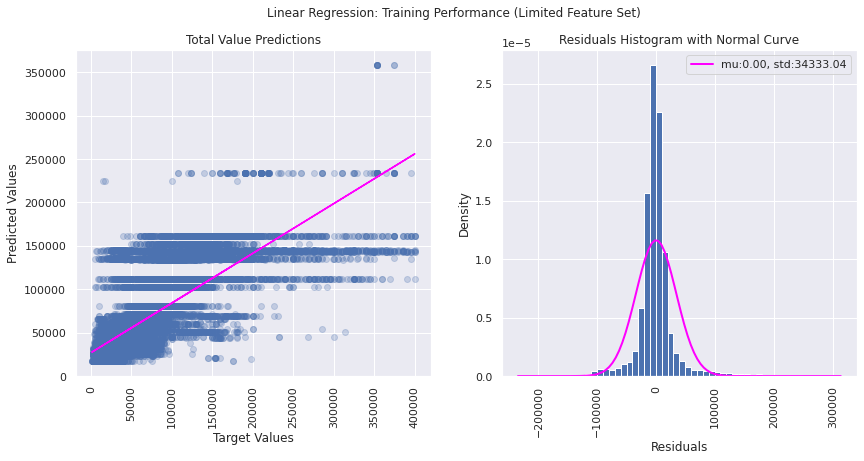

In [39]:
# create visualizations to evaluate performance
getPredictionPlot(train_y, y_pred_train, "Linear Regression: Training Performance (Limited Feature Set)")

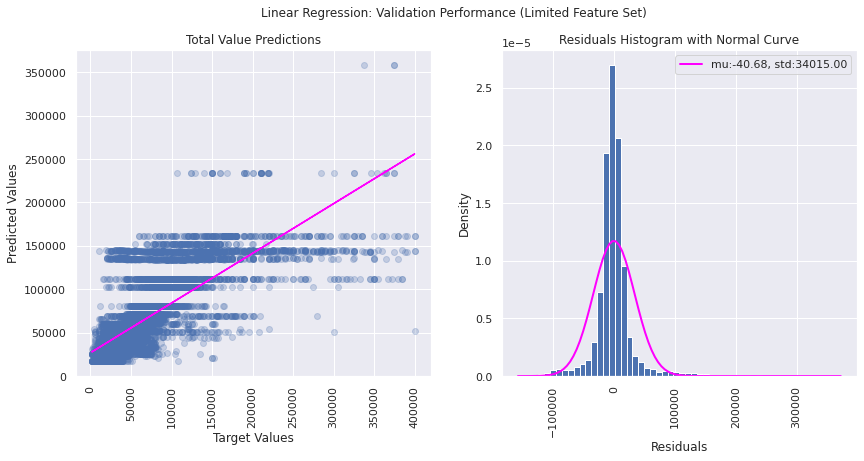

In [40]:
# create visualizations to evaluate performance
getPredictionPlot(val_y, y_pred_validation, "Linear Regression: Validation Performance (Limited Feature Set)")

I will re-run the model using more categorical variables.

In [41]:
# define the model
LRmodel = LinearRegression()
# define the data that will be used in the model
regression_cols = ["Property Class Description", "Neighborhood", "Front", "Age",
                   "Total Living Area", "# of Fireplaces", "# of Beds", 
                   "TotalBaths", "Overall Condition", "Building Style", 
                   "Heat Type"]
# save and fit the pipeline
OLSpipeline, train_x, train_y, train_time = fitLRModelPipeline(LRmodel, df, regression_cols)

LinearRegression() training time: 0.21397781372070312
Coefficients: 
 [  2878.61291958  -2878.61292645  31512.25427716 -30538.78876989
 -43739.10818155 121276.90160926  66482.92909509 -35883.34135464
 -37700.69899035  70150.10049148  69055.53291688 -37000.50436608
 -39029.60701554 -43771.30952744 -41537.48191463 -26884.23685651
 -17923.39071179 -16586.90885288  -7512.46259853 -21000.69679058
 -19336.43365511 -19920.047119   -15729.07753175 -43115.0217123
 -41259.85170266  39440.66052122  85714.01996494 -31313.04415716
 -17382.29850147 -25140.08318133 -33858.60786414  -9896.55604155
   9097.41550966 227502.83343043   -451.91973705 -31117.65052546
 -14891.2659831  -17712.25417154 -25301.95261429 -21972.77236219
  -9995.11811992  20300.00526057  36969.83783624 -20167.81734396
   1694.94712043  23158.50928942 -23051.11204514   4805.87023068
  61710.79402876 240648.50289317 -23332.56747545 -47183.18820046
 -26735.70928358 -33361.12845244  -9711.27683395 -26803.22460192
  -2260.37089315  104

In [42]:
# save predictions from data
val_x = val_df[regression_cols]
val_y = val_df["Total Value"]


y_pred_train = OLSpipeline.predict(train_x)
y_pred_validation = OLSpipeline.predict(val_x)

# update the results and evaluate performance of predictions on target
results_df = getRegressionMetrics(train_y, y_pred_train, results_df, "OLS", regression_cols, train_time, "Train")
results_df = getRegressionMetrics(val_y, y_pred_validation, results_df, "OLS", regression_cols, train_time, "Validation") 

Mean squared error: 1072310385.78
Root Mean squared error: 32746.15
Mean absolute error: 18162.59
Median absolute error: 9532.94
Coefficient of determination: 0.61

Sample of 10 predictions vs. target:
Predicted values:  [136019.  33985.  43283.  69676.  76061.  35846.  17467. 145093.  19669.
  35846.]
Target values:  SBL
1003800004027000    175000.0
0907200002032000     10000.0
0896700003003000     33800.0
0797100006030000     51100.0
1334800003004000     75000.0
0887400003012000     35500.0
1016900005054111     25000.0
0788400002006000    295000.0
0907900002024000     25000.0
0887400003019000     35000.0
Name: Total Value, dtype: float64
Mean squared error: 1058291763.17
Root Mean squared error: 32531.40
Mean absolute error: 18046.25
Median absolute error: 9544.55
Coefficient of determination: 0.61

Sample of 10 predictions vs. target:
Predicted values:  [ 53541.  11247.  76061. 209312.  29737.  43283.  51363.  51331.  43162.
  35846.]
Target values:  SBL
1334600001006000        6500

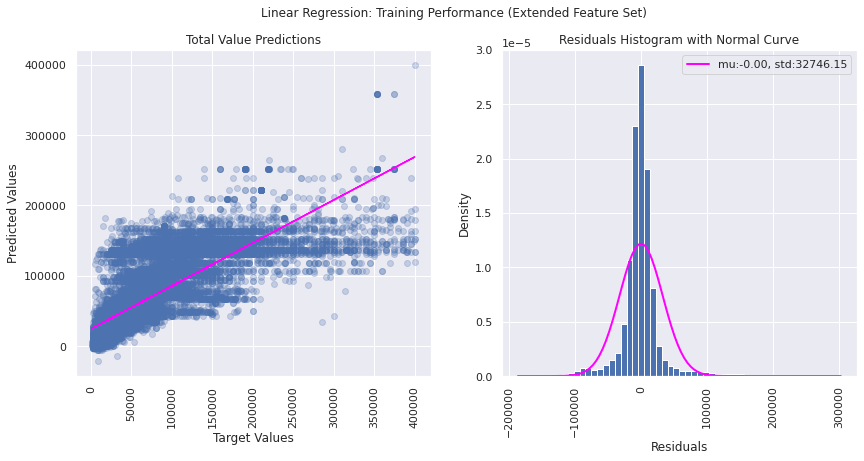

In [43]:
# create visualizations to evaluate performance
getPredictionPlot(train_y, y_pred_train, "Linear Regression: Training Performance (Extended Feature Set)")

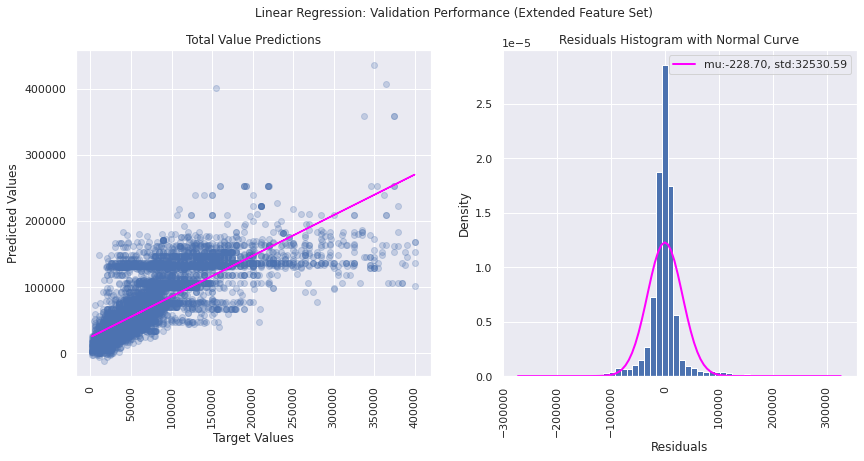

In [44]:
# create visualizations to evaluate performance
getPredictionPlot(val_y, y_pred_validation, "Linear Regression: Validation Performance (Extended Feature Set)")

## Linear Model trained with L1 prior as regularizer (aka the Lasso)

In [45]:
# define the model
LRmodel = Lasso()
# define the data that will be used in the model
regression_cols = ["Property Class Description", "Neighborhood", "Front", "Age",
                   "Total Living Area", "# of Fireplaces", "# of Beds", 
                   "TotalBaths"]
# save and fit the pipeline
LassoPipeline, train_x, train_y, train_time = fitLRModelPipeline(LRmodel, df, regression_cols)

Lasso() training time: 6.637567758560181
Coefficients: 
 [ 8.78114269e+03 -1.50240548e-06  5.88446246e+04 -1.42470250e+04
 -2.64549514e+04  1.81035011e+05  9.03253007e+04 -1.90909601e+04
 -1.36403097e+04  9.12523981e+04  9.26759834e+04 -2.07747414e+04
 -2.34999521e+04 -2.31476551e+04 -2.60764855e+04 -9.44808879e+03
 -5.52180392e+02  8.58687101e+02  9.57983287e+03 -3.63003298e+03
 -2.01802817e+03 -3.87251608e+03  7.56718961e+03 -2.60982337e+04
 -2.07652160e+04  5.95442894e+04  1.08616558e+05  1.35496261e+04
 -7.22293585e+02 -8.30416837e+03 -1.91859957e+04  8.70087403e+03
  2.83450344e+04  3.02275894e+05  1.70976134e+04 -1.43815039e+04
  6.99879053e+03  1.60448796e+03]
Intercept: 
 43540.16721178389


In [46]:
# save predictions from data
val_x = val_df[regression_cols]
val_y = val_df["Total Value"]


y_pred_train = LassoPipeline.predict(train_x)
y_pred_validation = LassoPipeline.predict(val_x)

# update the results and evaluate performance of predictions on target
results_df = getRegressionMetrics(train_y, y_pred_train, results_df, "Lasso", regression_cols, train_time, "Train")
results_df = getRegressionMetrics(val_y, y_pred_validation, results_df, "Lasso", regression_cols, train_time, "Validation") 

Mean squared error: 1178763857.97
Root Mean squared error: 34333.13
Mean absolute error: 19215.48
Median absolute error: 10303.28
Coefficient of determination: 0.57

Sample of 10 predictions vs. target:
Predicted values:  [144997.  48691.  42988.  69419.  80666.  37940.  17085. 142647.  17464.
  37940.]
Target values:  SBL
1003800004027000    175000.0
0907200002032000     10000.0
0896700003003000     33800.0
0797100006030000     51100.0
1334800003004000     75000.0
0887400003012000     35500.0
1016900005054111     25000.0
0788400002006000    295000.0
0907900002024000     25000.0
0887400003019000     35000.0
Name: Total Value, dtype: float64
Mean squared error: 1157008528.82
Root Mean squared error: 34014.83
Mean absolute error: 19010.33
Median absolute error: 10282.49
Coefficient of determination: 0.57

Sample of 10 predictions vs. target:
Predicted values:  [ 53180.  25866.  80666. 233356.  17442.  42988.  25866.  29174.  45145.
  37940.]
Target values:  SBL
1334600001006000        65

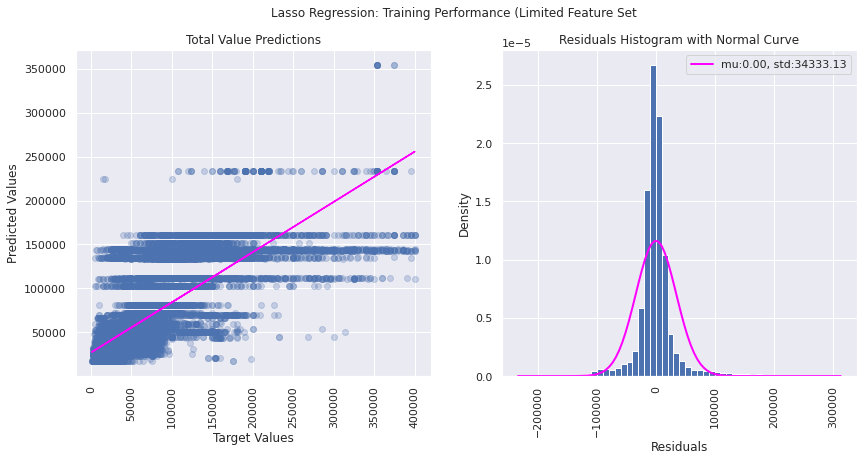

In [47]:
# create visualizations to evaluate performance
getPredictionPlot(train_y, y_pred_train, "Lasso Regression: Training Performance (Limited Feature Set")

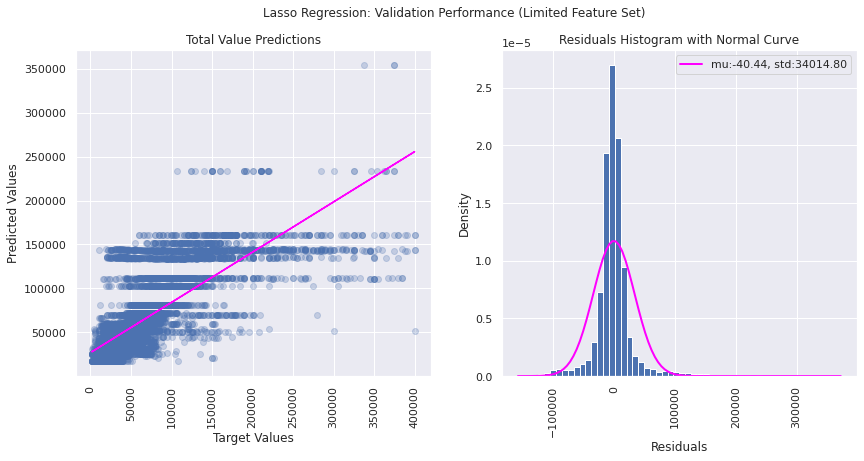

In [48]:
# create visualizations to evaluate performance
getPredictionPlot(val_y, y_pred_validation, "Lasso Regression: Validation Performance (Limited Feature Set)")

Running the model with more categorical variables.

In [49]:
# define the model
LRmodel = Lasso()
# define the data that will be used in the model
regression_cols = ["Property Class Description", "Neighborhood", "Front", "Age",
                   "Total Living Area", "# of Fireplaces", "# of Beds", 
                   "TotalBaths", "Overall Condition", "Building Style", 
                   "Heat Type"]
# save and fit the pipeline
LassoPipeline, train_x, train_y, train_time = fitLRModelPipeline(LRmodel, df, regression_cols)

Lasso() training time: 5.99009895324707
Coefficients: 
 [ 5.75064321e+03 -6.49044904e-07  4.93928159e+04 -1.25115178e+04
 -2.57625610e+04  1.38972538e+05  8.44045630e+04 -1.78979290e+04
 -1.95589097e+04  8.80756659e+04  8.70100075e+04 -1.90354823e+04
 -2.09625020e+04 -2.57177816e+04 -2.35634439e+04 -8.85677621e+03
  0.00000000e+00  1.30418261e+03  1.03998989e+04 -3.02270106e+03
 -1.37250099e+03 -1.95006393e+03  2.12433015e+03 -2.51084037e+04
 -2.32768256e+04  5.73664492e+04  1.03650396e+05 -1.32197479e+04
  5.41670974e+02 -7.16770550e+03 -1.58179997e+04  8.01472052e+03
  2.70334750e+04  2.41368412e+05  1.74764065e+04 -1.31351305e+04
  3.00094395e+03  2.02204033e+02 -2.09871253e+04 -1.77655205e+04
 -5.77688279e+03  2.45175537e+04  3.72294338e+04  0.00000000e+00
  2.12077933e+04  4.24689991e+04 -2.84913760e+03  2.49110462e+04
  7.88950045e+04  2.24891938e+05 -3.16368748e+03 -2.56929160e+04
 -0.00000000e+00 -1.26491366e+04  1.02104390e+04 -6.07012640e+03
  1.77665079e+04  3.07576662e+04 -

In [50]:
# save predictions from data
val_x = val_df[regression_cols]
val_y = val_df["Total Value"]


y_pred_train = LassoPipeline.predict(train_x)
y_pred_validation = LassoPipeline.predict(val_x)

# update the results and evaluate performance of predictions on target
results_df = getRegressionMetrics(train_y, y_pred_train, results_df, "Lasso", regression_cols, train_time, "Train")
results_df = getRegressionMetrics(val_y, y_pred_validation, results_df, "Lasso", regression_cols, train_time, "Validation") 

Mean squared error: 1072396954.99
Root Mean squared error: 32747.47
Mean absolute error: 18162.26
Median absolute error: 9533.10
Coefficient of determination: 0.61

Sample of 10 predictions vs. target:
Predicted values:  [136023.  34002.  43263.  69653.  76047.  35878.  17500. 145061.  19699.
  35878.]
Target values:  SBL
1003800004027000    175000.0
0907200002032000     10000.0
0896700003003000     33800.0
0797100006030000     51100.0
1334800003004000     75000.0
0887400003012000     35500.0
1016900005054111     25000.0
0788400002006000    295000.0
0907900002024000     25000.0
0887400003019000     35000.0
Name: Total Value, dtype: float64
Mean squared error: 1056275156.44
Root Mean squared error: 32500.39
Mean absolute error: 18035.27
Median absolute error: 9552.69
Coefficient of determination: 0.61

Sample of 10 predictions vs. target:
Predicted values:  [ 53481.  11262.  76047. 208916.  29797.  43263.  51326.  51370.  43119.
  35878.]
Target values:  SBL
1334600001006000        6500

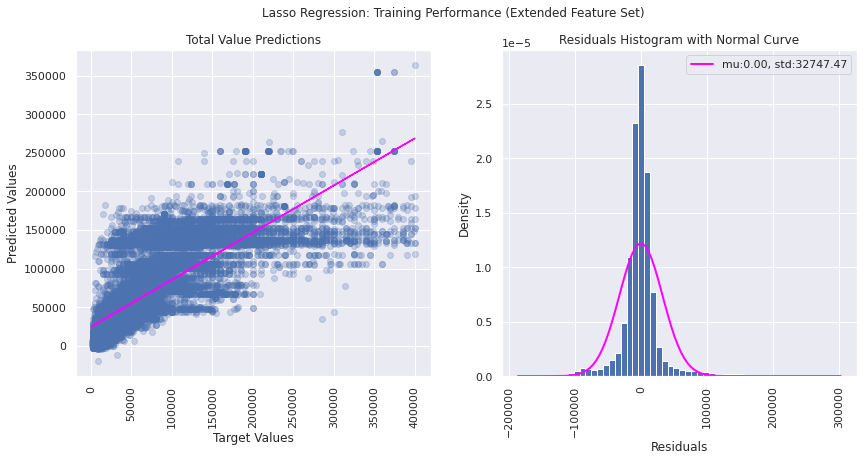

In [51]:
# create visualizations to evaluate performance
getPredictionPlot(train_y, y_pred_train, "Lasso Regression: Training Performance (Extended Feature Set)")

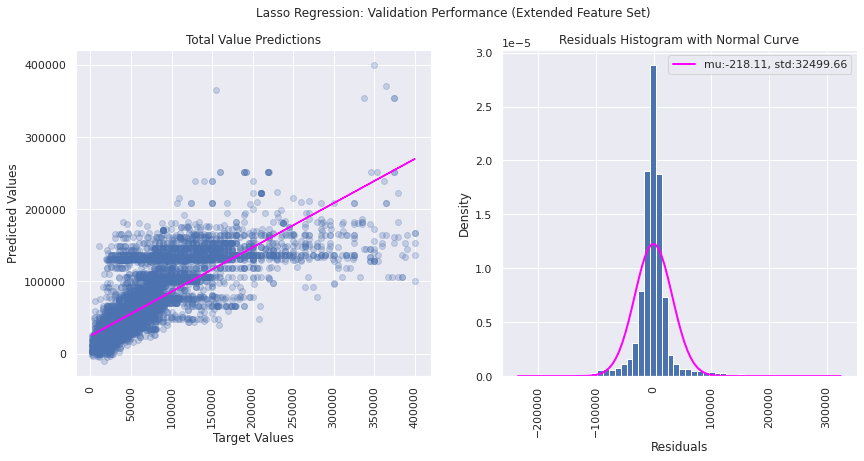

In [52]:
# create visualizations to evaluate performance
getPredictionPlot(val_y, y_pred_validation, "Lasso Regression: Validation Performance (Extended Feature Set)")

## Linear least squares with l2 regularization (aka Ridge)

In [53]:
# define the model
LRmodel = Ridge()
# define the data that will be used in the model
regression_cols = ["Property Class Description", "Neighborhood", "Front", "Age",
                   "Total Living Area", "# of Fireplaces", "# of Beds", 
                   "TotalBaths"]
# save and fit the pipeline
RidgePipeline, train_x, train_y, train_time = fitLRModelPipeline(LRmodel, df, regression_cols)

Ridge() training time: 0.05294156074523926
Coefficients: 
 [  4400.8337049   -4400.83369807  37167.94849782 -35880.95485762
 -48058.55061096 158607.88613082  68717.21075287 -40637.90563486
 -35113.36454437  69622.36200364  70959.83236475 -42380.50209225
 -45147.08773086 -44893.18772321 -47663.72755536 -31029.28400457
 -22170.11626707 -20744.92149191 -11978.50351367 -25232.56523773
 -23640.50621393 -25536.2375136  -13866.89921232 -47763.89340616
 -42381.78135458  37929.14875313  86957.01833202  -7881.66405335
 -22354.70723629 -29905.72514436 -40712.36080368 -12925.99571856
   6736.13705115 256154.91849934  -4486.60256029 -35961.46232425
 -14567.24435109 -19936.71122873]
Intercept: 
 69546.52073002256


In [54]:
# save predictions from data
val_x = val_df[regression_cols]
val_y = val_df["Total Value"]


y_pred_train = RidgePipeline.predict(train_x)
y_pred_validation = RidgePipeline.predict(val_x)

# update the results and evaluate performance of predictions on target
results_df = getRegressionMetrics(train_y, y_pred_train, results_df, "Ridge", regression_cols, train_time, "Train")
results_df = getRegressionMetrics(val_y, y_pred_validation, results_df, "Ridge", regression_cols, train_time, "Validation") 

Mean squared error: 1178969176.13
Root Mean squared error: 34336.12
Mean absolute error: 19223.82
Median absolute error: 10306.85
Coefficient of determination: 0.57

Sample of 10 predictions vs. target:
Predicted values:  [144907.  48715.  42976.  69461.  80683.  37986.  17087. 142665.  17482.
  37986.]
Target values:  SBL
1003800004027000    175000.0
0907200002032000     10000.0
0896700003003000     33800.0
0797100006030000     51100.0
1334800003004000     75000.0
0887400003012000     35500.0
1016900005054111     25000.0
0788400002006000    295000.0
0907900002024000     25000.0
0887400003019000     35000.0
Name: Total Value, dtype: float64
Mean squared error: 1157206134.35
Root Mean squared error: 34017.73
Mean absolute error: 19016.05
Median absolute error: 10285.21
Coefficient of determination: 0.57

Sample of 10 predictions vs. target:
Predicted values:  [ 53202.  25889.  80683. 232555.  17382.  42976.  25889.  29054.  45209.
  37986.]
Target values:  SBL
1334600001006000        65

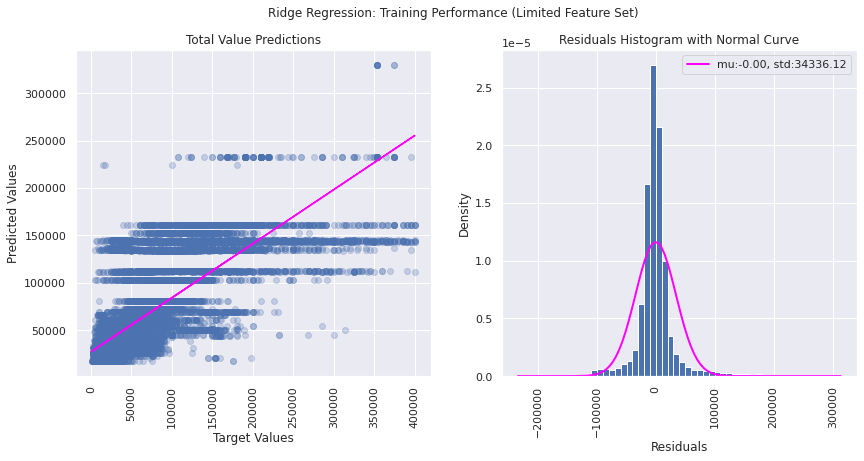

In [55]:
# create visualizations to evaluate performance
getPredictionPlot(train_y, y_pred_train, "Ridge Regression: Training Performance (Limited Feature Set)")

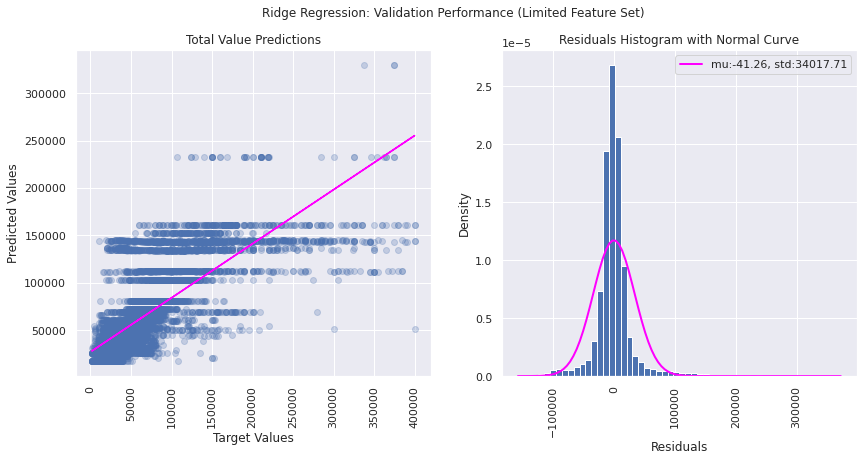

In [56]:
# create visualizations to evaluate performance
getPredictionPlot(val_y, y_pred_validation, "Ridge Regression: Validation Performance (Limited Feature Set)")

Running the model with more categorical variables.

In [57]:
# define the model
LRmodel = Ridge()
# define the data that will be used in the model
regression_cols = ["Property Class Description", "Neighborhood", "Front", "Age",
                   "Total Living Area", "# of Fireplaces", "# of Beds", 
                   "TotalBaths", "Overall Condition", "Building Style", 
                   "Heat Type"]
# save and fit the pipeline
RidgePipeline, train_x, train_y, train_time = fitLRModelPipeline(LRmodel, df, regression_cols)

Ridge() training time: 0.10104703903198242
Coefficients: 
 [ 2.87883138e+03 -2.87883135e+03  3.18546121e+04 -2.99331598e+04
 -4.31407108e+04  1.20208561e+05  6.70231836e+04 -3.52482571e+04
 -3.69333852e+04  7.06505937e+04  6.96634872e+04 -3.65040051e+04
 -3.83611779e+04 -4.29833450e+04 -4.09581389e+04 -2.62759972e+04
 -1.72248729e+04 -1.59221340e+04 -6.97456787e+03 -2.04219304e+04
 -1.87681366e+04 -1.93546946e+04 -1.51562488e+04 -4.24933737e+04
 -4.06666203e+04  3.99825009e+04  8.62579112e+04 -3.07783706e+04
 -1.68150071e+04 -2.45657138e+04 -3.28940144e+04 -9.43475150e+03
  9.66888219e+03  2.08256375e+05  1.06222938e+02 -3.04958152e+04
 -1.42414301e+04 -1.71264708e+04 -2.37919832e+04 -2.04722015e+04
 -8.48087728e+03  2.19138924e+04  3.08311696e+04 -1.25239919e+04
  8.00047364e+03  3.14597467e+04 -1.53390579e+04  1.24614542e+04
  5.59063193e+04  9.90124244e+04 -1.56541169e+04 -3.88466887e+04
 -1.54706299e+04 -2.41076072e+04 -1.84594431e+03 -1.75907254e+04
  6.05789757e+03  1.95618574e+0

In [58]:
# save predictions from data
val_x = val_df[regression_cols]
val_y = val_df["Total Value"]


y_pred_train = RidgePipeline.predict(train_x)
y_pred_validation = RidgePipeline.predict(val_x)

# update the results and evaluate performance of predictions on target
results_df = getRegressionMetrics(train_y, y_pred_train, results_df, "Ridge", regression_cols, train_time, "Train")
results_df = getRegressionMetrics(val_y, y_pred_validation, results_df, "Ridge", regression_cols, train_time, "Validation") 

Mean squared error: 1073131371.59
Root Mean squared error: 32758.68
Mean absolute error: 18175.85
Median absolute error: 9527.37
Coefficient of determination: 0.61

Sample of 10 predictions vs. target:
Predicted values:  [136052.  33975.  43406.  69625.  76057.  35892.  17490. 145060.  19672.
  35892.]
Target values:  SBL
1003800004027000    175000.0
0907200002032000     10000.0
0896700003003000     33800.0
0797100006030000     51100.0
1334800003004000     75000.0
0887400003012000     35500.0
1016900005054111     25000.0
0788400002006000    295000.0
0907900002024000     25000.0
0887400003019000     35000.0
Name: Total Value, dtype: float64
Mean squared error: 1054519472.97
Root Mean squared error: 32473.37
Mean absolute error: 18044.27
Median absolute error: 9540.78
Coefficient of determination: 0.61

Sample of 10 predictions vs. target:
Predicted values:  [ 53596.  11256.  76057. 208309.  29786.  43406.  51363.  51520.  43161.
  35892.]
Target values:  SBL
1334600001006000        6500

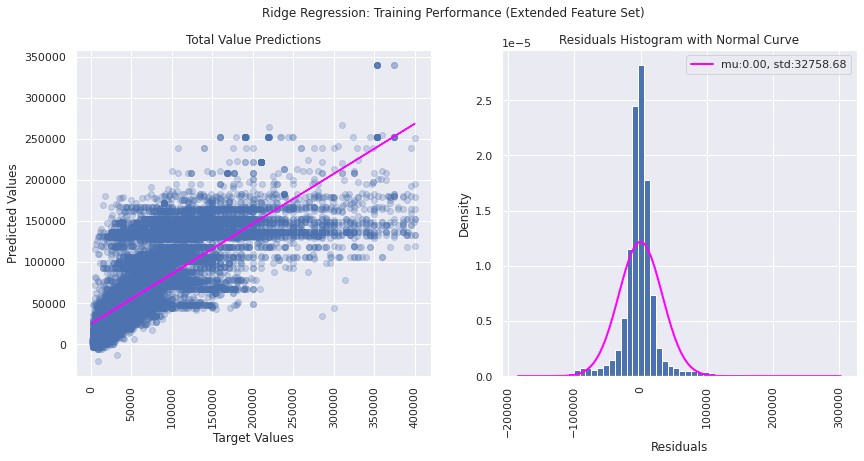

In [59]:
# create visualizations to evaluate performance
getPredictionPlot(train_y, y_pred_train, "Ridge Regression: Training Performance (Extended Feature Set)")

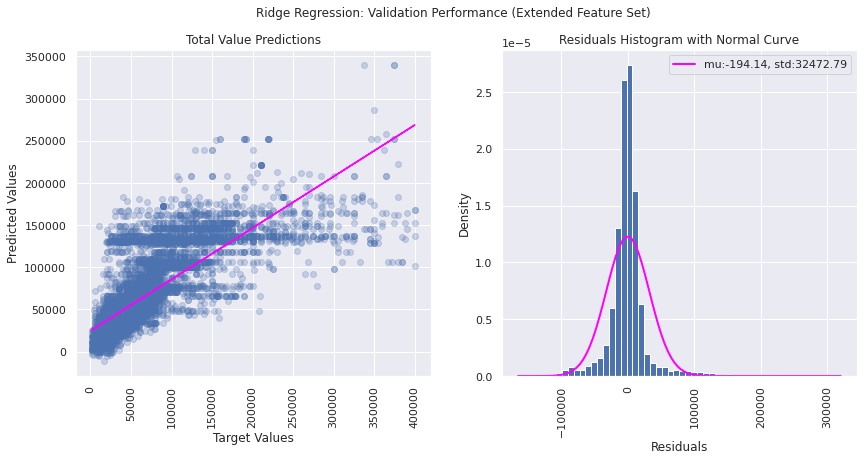

In [60]:
# create visualizations to evaluate performance
getPredictionPlot(val_y, y_pred_validation, "Ridge Regression: Validation Performance (Extended Feature Set)")

## Huber: Linear regression model that is robust to outliers.

In [61]:
# define the model
LRmodel = HuberRegressor()
# define the data that will be used in the model
regression_cols = ["Property Class Description", "Neighborhood", "Front", "Age",
                   "Total Living Area", "# of Fireplaces", "# of Beds", 
                   "TotalBaths"]
# save and fit the pipeline
HuberPipeline, train_x, train_y, train_time = fitLRModelPipeline(LRmodel, df, regression_cols)

HuberRegressor() training time: 0.8823175430297852
Coefficients: 
 [  7335.2277539    6900.43221989  13993.41424725 -26584.92661131
 -43720.95893635 146650.01382728  56852.38562774 -31443.49327994
 -35370.84482197  69500.7463078   79695.71035104 -34095.99085901
 -37584.37258121 -43603.56528861 -39776.50366892 -26093.41202598
 -16479.7241745  -10448.50951584  -2558.52009029 -15259.78799601
 -17414.29535213 -14723.36749597 -18809.81936383 -39924.86857946
 -37604.40121553  39508.98728046  84456.99521253  10049.19482972
 -12896.03856251 -22458.16721683 -32138.81125491  -4898.29363246
  14727.70542821 121314.34363219  -1667.50222943 -28009.31158241
  -7950.81072586 -20997.539709  ]
Intercept: 
 53959.48334188777


In [62]:
# save predictions from data
val_x = val_df[regression_cols]
val_y = val_df["Total Value"]


y_pred_train = HuberPipeline.predict(train_x)
y_pred_validation = HuberPipeline.predict(val_x)

# update the results and evaluate performance of predictions on target
results_df = getRegressionMetrics(train_y, y_pred_train, results_df, "Huber", regression_cols, train_time, "Train")
results_df = getRegressionMetrics(val_y, y_pred_validation, results_df, "Huber", regression_cols, train_time, "Validation") 

Mean squared error: 1250470012.08
Root Mean squared error: 35361.99
Mean absolute error: 18109.54
Median absolute error: 8138.96
Coefficient of determination: 0.55

Sample of 10 predictions vs. target:
Predicted values:  [140990.  46035.  44380.  59627.  76022.  33285.  17139. 118147.  21083.
  33285.]
Target values:  SBL
1003800004027000    175000.0
0907200002032000     10000.0
0896700003003000     33800.0
0797100006030000     51100.0
1334800003004000     75000.0
0887400003012000     35500.0
1016900005054111     25000.0
0788400002006000    295000.0
0907900002024000     25000.0
0887400003019000     35000.0
Name: Total Value, dtype: float64
Mean squared error: 1229434579.97
Root Mean squared error: 35063.29
Mean absolute error: 17942.25
Median absolute error: 8149.40
Coefficient of determination: 0.54

Sample of 10 predictions vs. target:
Predicted values:  [ 50846.  17574.  76022. 207945.  20935.  44380.  17574.  17691.  39862.
  33285.]
Target values:  SBL
1334600001006000        6500

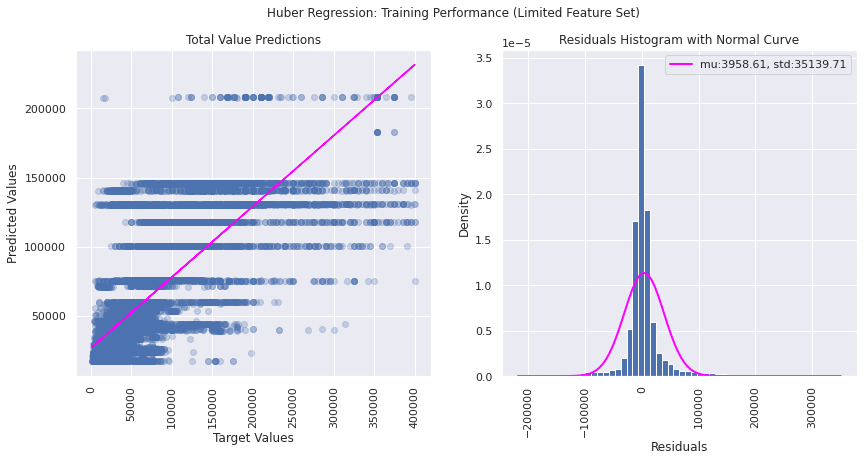

In [63]:
# create visualizations to evaluate performance
getPredictionPlot(train_y, y_pred_train, "Huber Regression: Training Performance (Limited Feature Set)")

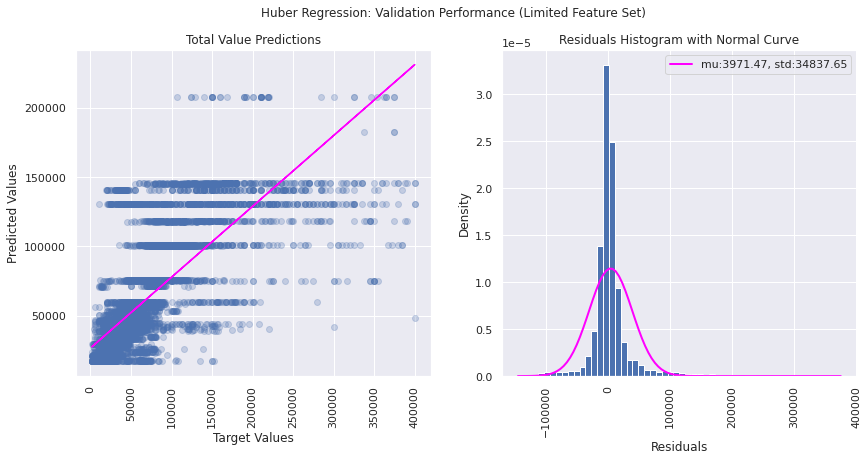

In [64]:
# create visualizations to evaluate performance
getPredictionPlot(val_y, y_pred_validation, "Huber Regression: Validation Performance (Limited Feature Set)")

Adding more categorical columns

In [65]:
# define the model
LRmodel = HuberRegressor()
# define the data that will be used in the model
regression_cols = ["Property Class Description", "Neighborhood", "Front", "Age",
                   "Total Living Area", "# of Fireplaces", "# of Beds", 
                   "TotalBaths", "Overall Condition", "Building Style", 
                   "Heat Type"]
# save and fit the pipeline
HuberPipeline, train_x, train_y, train_time = fitLRModelPipeline(LRmodel, df, regression_cols)

HuberRegressor() training time: 0.9545276165008545
Coefficients: 
 [ 14670.03163516  15739.5138924   14919.63194324 -20067.30763129
 -35672.05808913 123000.30831754  58968.78508897 -25564.01763333
 -28200.19689852  73450.56696678  83711.23361806 -27690.07703575
 -29500.85280974 -36041.84002478 -32801.29277838 -19621.6765569
 -10719.5504583   -5887.35300892   2555.8214409  -10523.01007473
 -11689.16947773  -8695.87178989 -15009.94423283 -33635.18431606
 -31861.0983956   43752.48397309  87991.18087786 -19930.44070027
  -7354.89547407 -16503.42228184 -24379.13472874   -676.3818074
  18041.62496021  14716.16185741   3711.72113249 -21762.53051432
  -5257.16801307 -15365.4999174   -6750.82218789   -761.85043631
   6742.931622    24261.28767766   6917.99885208   -487.35544299
  17555.46585069  26157.25495468  -3616.94852857  24565.6062434
  15272.41418266   1635.12909527  -8064.11214172 -20072.58747266
  -3614.79463897 -12987.56542973   -758.69354503  -8996.18903103
  -1242.32172488  21343.38

In [66]:
# save predictions from data
val_x = val_df[regression_cols]
val_y = val_df["Total Value"]


y_pred_train = HuberPipeline.predict(train_x)
y_pred_validation = HuberPipeline.predict(val_x)

# update the results and evaluate performance of predictions on target
results_df = getRegressionMetrics(train_y, y_pred_train, results_df, "Huber", regression_cols, train_time, "Train")
results_df = getRegressionMetrics(val_y, y_pred_validation, results_df, "Huber", regression_cols, train_time, "Validation") 

Mean squared error: 1155023228.41
Root Mean squared error: 33985.63
Mean absolute error: 17153.17
Median absolute error: 7721.32
Coefficient of determination: 0.58

Sample of 10 predictions vs. target:
Predicted values:  [138152.  36413.  44791.  65729.  72482.  32678.  19838. 117501.  22709.
  32678.]
Target values:  SBL
1003800004027000    175000.0
0907200002032000     10000.0
0896700003003000     33800.0
0797100006030000     51100.0
1334800003004000     75000.0
0887400003012000     35500.0
1016900005054111     25000.0
0788400002006000    295000.0
0907900002024000     25000.0
0887400003019000     35000.0
Name: Total Value, dtype: float64
Mean squared error: 1139979026.67
Root Mean squared error: 33763.58
Mean absolute error: 17015.18
Median absolute error: 7801.05
Coefficient of determination: 0.57

Sample of 10 predictions vs. target:
Predicted values:  [ 56130.  11264.  72482. 184263.  25967.  44791.  51399.  51029.  36732.
  32678.]
Target values:  SBL
1334600001006000        6500

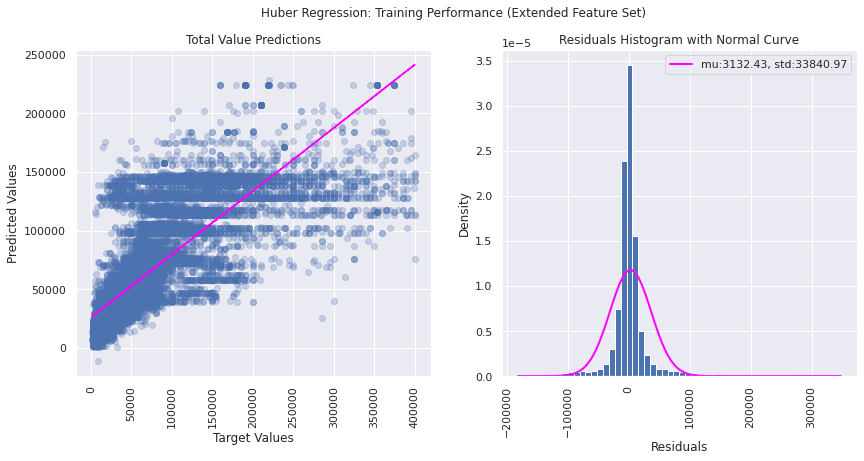

In [67]:
# create visualizations to evaluate performance
getPredictionPlot(train_y, y_pred_train, "Huber Regression: Training Performance (Extended Feature Set)")

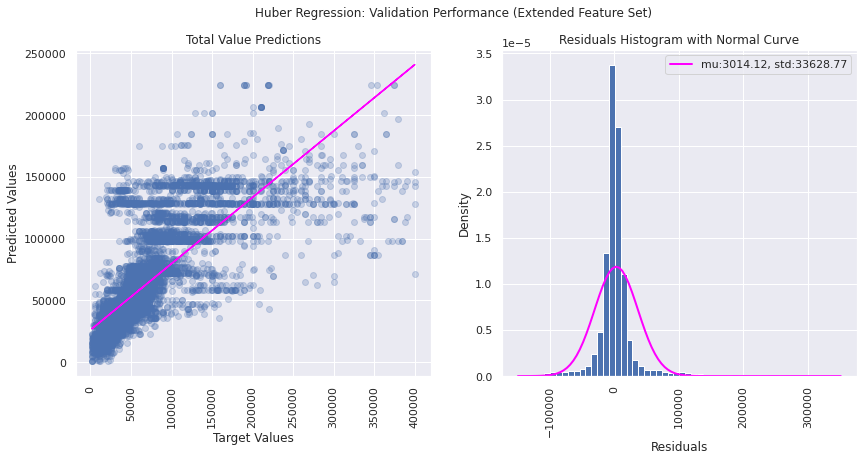

In [68]:
# create visualizations to evaluate performance
getPredictionPlot(val_y, y_pred_validation, "Huber Regression: Validation Performance (Extended Feature Set)")

## Summary of Results

In [ ]:
#results_df

,Model,Features,MSE,RMSE,Mean Abs. Error,Median Abs. Error,R2 Score,Train Time,Test Partition
0,OLS,"[Property Class Description, Neighborhood, Fro...",1.178758e+09,34333.04,19215.90,10290.11,0.57,0.076210,Train
1,OLS,"[Property Class Description, Neighborhood, Fro...",1.157022e+09,34015.03,19010.20,10274.25,0.57,0.076210,Validation
2,OLS,"[Property Class Description, Neighborhood, Fro...",1.072310e+09,32746.15,18162.59,9532.94,0.61,0.240016,Train
3,OLS,"[Property Class Description, Neighborhood, Fro...",1.058292e+09,32531.40,18046.25,9544.55,0.61,0.240016,Validation
4,Lasso,"[Property Class Description, Neighborhood, Fro...",1.178764e+09,34333.13,19215.48,10303.28,0.57,5.804857,Train
5,Lasso,"[Property Class Description, Neighborhood, Fro...",1.157009e+09,34014.83,19010.33,10282.49,0.57,5.804857,Validation
6,Lasso,"[Property Class Description, Neighborhood, Fro...",1.072397e+09,32747.47,18162.26,9533.10,0.61,5.126974,Train
7,Lasso,"[Property Class Description, Neighborhood, Fro...",1.056275e+09,32500.39,18035.27,9552.69,0.61,5.126974,Validation
8,Ridge,"[Property Class Description, Neighborhood, Fro...",1.178969e+09,34336.12,19223.82,10306.85,0.57,0.063592,Train
9,Ridge,"[Property Class Description, Neighborhood, Fro...",1.157206e+09,34017.73,19016.05,10285.21,0.57,0.063592,Validation


In [ ]:
#results_df.to_csv("/content/drive/MyDrive/ML/ML-Project/data/results/LinearRegressionResults.csv")